In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

figures = f"{FIGURES}/som_intransivity"

In [2]:
exp_s_transition = Experiment(DataHandler("ERA5", "plev", "s", "6H", "all", (144, 158), -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=True))
exp_s_ja = Experiment(DataHandler("ERA5", "plev", "s", "6H", "all", (159, 243), -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=True))
region = exp_s_ja.data_handler.region

In [3]:
net, centers, labels = exp_s_transition.som_cluster(
    2,
    3,
    metric="euclidean",
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=50, start_learning_rate=0.05),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
labels = xr.DataArray(labels, coords={"time": exp_s_transition.data_handler.get_sample_dims()["time"]})
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s_transition.da.time, "cluster": np.arange(net.n_nodes)})

In [4]:
winners = {lab: [] for lab in np.concatenate([[-1], np.arange(net.n_nodes)])}
for year in YEARS:
    time_mask_ = labels.time.dt.year.values == year
    un, co = np.unique(labels[time_mask_].values, return_counts=True)
    co = co / time_mask_.sum()
    winner = np.where(co > 0.33)[0]
    if len(winner) == 0:
        winner = -1
        co = co.tolist()
    else:
        co = co[winner[0]]
        winner = un[winner[0]]
    winners[winner].append(year)

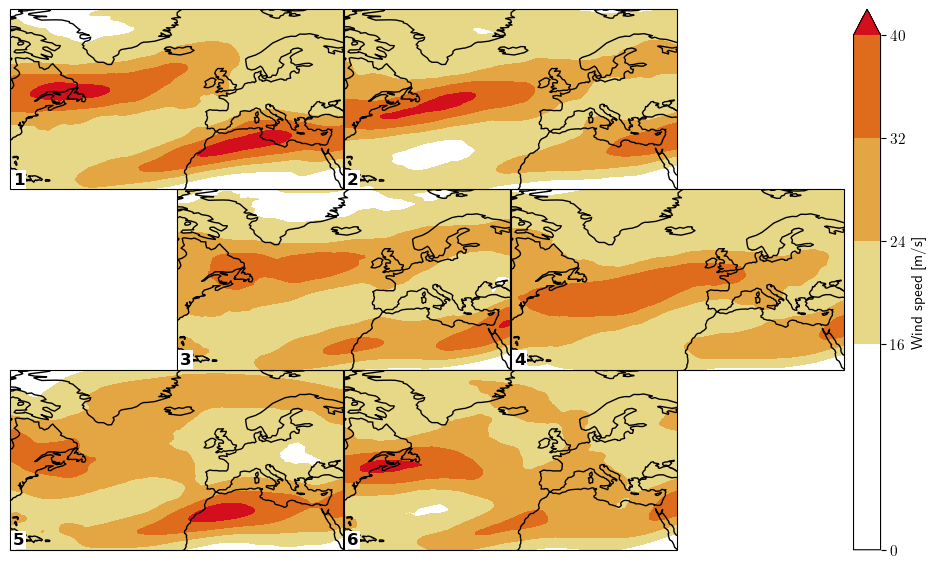

In [5]:
clu = Clusterplot(net.height, net.width, region, honeycomb=True, numbering=True)
_ = clu.add_contourf(
    centers,
    cmap=colormaps.cet_l_wyor,
    transparify=1,
    levels=[0, 16, 24, 32, 40],
    cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.01}
)
clu.resize_relative([0.95, 1])
plt.savefig(f'{figures}/transition_wind.png')

In [6]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    group = np.concatenate(group)
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    
    maxdx = net.width
    maxdy = net.height
    dx = np.abs(coords[:, 0] - com[0, 0])
    dy = np.abs(coords[:, 1] - com[0, 1])
    mask_periodic = dx > maxdx
    dx[mask_periodic] = maxdx - dx[mask_periodic]
    mask_periodic = dy > maxdy
    dy[mask_periodic] = maxdy - dy[mask_periodic]
    stdx = np.sqrt(np.sum(dx ** 2) / (len(dx) - 1))
    stdy = np.sqrt(np.sum(dy ** 2) / (len(dy) - 1))
    variab = np.asarray([stdx, stdy])
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))
    group = []
    
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

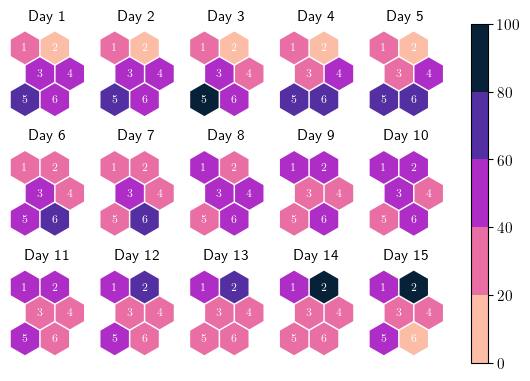

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(TEXTWIDTH_IN, 4.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 100.1, 20), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for step, (tsw, ax) in enumerate(zip(timestepwise, axes.ravel())):
    unique, counts = tsw[2], tsw[3]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Day {step + 1}", pad=5)
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${to_prettier_order(i, 2, 3)}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{figures}/transition_daily_pathway.png")

In [8]:
da = exp_s_transition.da
df = pd.read_csv(f"{DATADIR}/ERA5/daily_nao.csv", delimiter=",")
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
nao_summer = series.interp_like(da)
nao_on_map = timeseries_on_map(nao_summer, net.bmus)[0]

yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
pvalues = trends.copy()
for k, yearly_ in enumerate(yearly.T):
    trends[k], _, _, pvalues[k], _ = linregress(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0]
    )


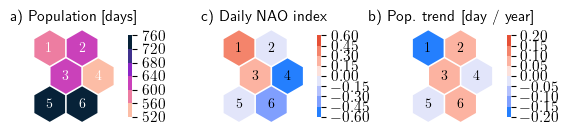

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.5), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Population [days]", pad=2)
cmap = colormaps.cet_d_bwr
fig, axes[2] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    # norm=BoundaryNorm(np.linspace(-0.3, 0.3, 7), cmap.N, extend="both"),
    discretify=True,
    fig=fig,
    ax=axes[2],
)
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
# axes[2].scatter(*coords.T, s=260, edgecolors="black", marker="h", linewidths=1., facecolors="none")
axes[2].scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
axes[2].set_title("b) Pop. trend [day / year]", pad=2)
fig, axes[1] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[1],
    cmap=cmap,
    discretify=True,
    # norm=BoundaryNorm(np.linspace(-0.75, 0.75, 7), cmap.N)
)
axes[1].set_title("c) Daily NAO index", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j == 0 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${to_prettier_order(i, 2, 3)}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{figures}/transition_pop_nao_trend.png')

In [10]:
net, centers, labels = exp_s_ja.som_cluster(
    4,
    4,
    metric="euclidean",
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=50, start_learning_rate=0.05),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
labels = xr.DataArray(labels, coords={"time": exp_s_ja.data_handler.get_sample_dims()["time"]})
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s_ja.da.time, "cluster": np.arange(net.n_nodes)})

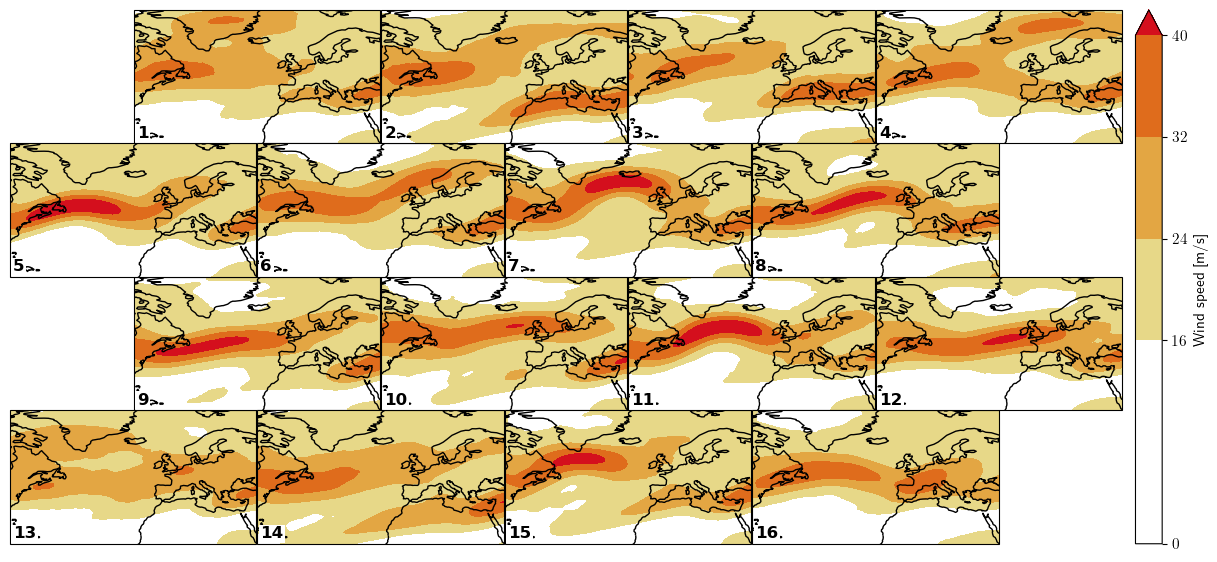

In [11]:
clu = Clusterplot(net.height, net.width, region, honeycomb=True, numbering=True)
_ = clu.add_contourf(
    centers,
    cmap=colormaps.cet_l_wyor,
    transparify=1,
    levels=[0, 16, 24, 32, 40],
    cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.01}
)
clu.resize_relative([0.95, 1])
plt.savefig(f'{figures}/JA_wind.png')

In [12]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    
    maxdx = net.width
    maxdy = net.height
    dx = np.abs(coords[:, 0] - com[0, 0])
    dy = np.abs(coords[:, 1] - com[0, 1])
    mask_periodic = dx > maxdx
    dx[mask_periodic] = maxdx - dx[mask_periodic]
    mask_periodic = dy > maxdy
    dy[mask_periodic] = maxdy - dy[mask_periodic]
    stdx = np.sqrt(np.sum(dx ** 2) / (len(dx) - 1))
    stdy = np.sqrt(np.sum(dy ** 2) / (len(dy) - 1))
    variab = np.asarray([stdx, stdy])
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))
    group = []
    
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

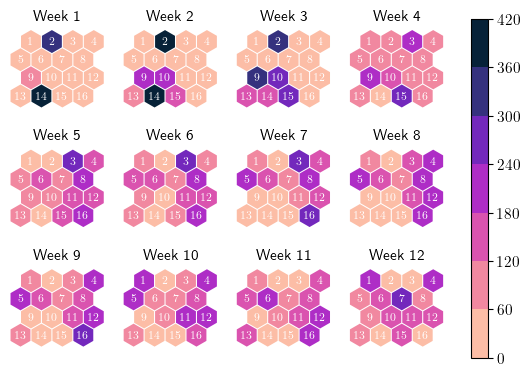

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(TEXTWIDTH_IN, 4.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 450.1, 60), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for step, (tsw, ax) in enumerate(zip(timestepwise, axes.ravel())):
    unique, counts = tsw[2], tsw[3]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step + 1}", pad=5)
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${to_prettier_order(i, 4, 4)}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{figures}/ja_weekly_pathway.png")

In [14]:
da = exp_s_ja.da
df = pd.read_csv(f"{DATADIR}/ERA5/daily_nao.csv", delimiter=",")
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
nao_summer = series.interp_like(da)
nao_on_map = timeseries_on_map(nao_summer, net.bmus)[0]

yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
pvalues = trends.copy()
for k, yearly_ in enumerate(yearly.T):
    trends[k], _, _, pvalues[k], _ = linregress(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0]
    )


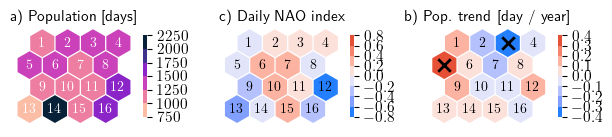

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.5), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Population [days]", pad=2)
cmap = colormaps.cet_d_bwr
fig, axes[2] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    # norm=BoundaryNorm(np.linspace(-0.3, 0.3, 7), cmap.N, extend="both"),
    discretify=True,
    fig=fig,
    ax=axes[2],
)
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
# axes[2].scatter(*coords.T, s=260, edgecolors="black", marker="h", linewidths=1., facecolors="none")
axes[2].scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
axes[2].set_title("b) Pop. trend [day / year]", pad=2)
fig, axes[1] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[1],
    cmap=cmap,
    discretify=True,
    # norm=BoundaryNorm(np.linspace(-0.75, 0.75, 7), cmap.N)
)
axes[1].set_title("c) Daily NAO index", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j == 0 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${to_prettier_order(i, 4, 4)}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{figures}/ja_pop_nao_trend.png')

In [16]:
from scipy.stats import t as t_distrib

labels = pd.read_csv("hihi.csv", index_col=0).iloc[:, 0]
labels.index = pd.to_datetime(labels.index)
labels = xr.DataArray(labels).rename("labels")
mask = labels_to_mask(labels)
mask = xr.DataArray(mask, coords={"time": labels.time.values, "cluster": np.arange(mask.shape[1])})
yearly = mask.resample(time="1YE").sum()
mu1 = yearly.mean("time")
s1 = yearly.var("time")
n1 = yearly.shape[0]
ts = {}
ps = {}
dofs = {}
diffs = {}
all_years = np.unique(yearly.time.dt.year.values)
prettier_sorted = np.asarray(list(winners))
prettier_sorted = prettier_sorted[np.argsort(to_prettier_order(prettier_sorted, 2, 3))]
winners = {key: winners[key] for key in prettier_sorted}
for winnerkey, yearlist in winners.items():
    this_distrib = yearly.sel(time=np.isin(yearly.time.dt.year, yearlist))
    mu2 = this_distrib.mean("time")
    s2 = this_distrib.var("time")
    n2 = this_distrib.shape[0]
    s = np.sqrt(s1 / n1 + s2 / n2)
    t = (mu1 - mu2) / s
    dof = s ** 4 / ((s1 / n1) ** 2 / (n1 - 1) + (s2 / n2) ** 2 / (n2 - 1))
    ts[winnerkey] = t.values
    dofs[winnerkey] = dof.values
    ps[winnerkey] = t_distrib.cdf(t.values, dof.values)
    diffs[winnerkey] = (mu1 - mu2).values

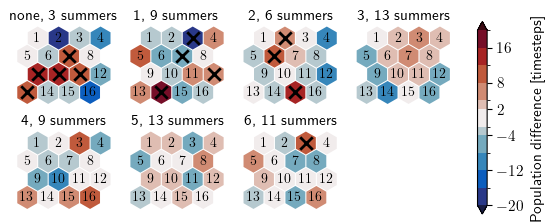

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(TEXTWIDTH_IN, 2.5), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.balance
norm = BoundaryNorm([-20, -16, -12, -8, -4, -2, 2, 4, 8, 12, 16, 20], cmap.N, extend="both")
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional", label="Population difference [timesteps]")
for winner, ax in zip(prettier_sorted, axes.ravel()):
    fig, ax = net.plot_on_map(
        diffs[winner],
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    len_ = len(winners[winner])
    pvals = ps[winner]
    where_signif = np.where((pvals < 0.025) | (pvals > 0.975))[0]
    signif = net.neighborhoods.coordinates[where_signif]
    ax.scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
    if winner == -1:
        winner = "none"
    else:
        winner = to_prettier_order(winner, 2, 3)
    ax.set_title(f"{winner}, {len_} summers", pad=2)
    for i, c in enumerate(coords):
        x, y = c
        if i in where_signif:
            continue
        ax.text(x, y, f'${to_prettier_order(i, 4, 4)}$', va='center', ha='center', color=color, fontsize=10)
axes.ravel()[-1].set_visible(False)
fig.set_tight_layout(False)
fig.savefig(f'{figures}/pop_differences.png')

In [51]:
np.sort(list(winners))

array([-1,  0,  1,  2,  3,  4,  5])

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(TEXTWIDTH_IN, 2.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.balance
norm = BoundaryNorm(np.delete(np.arange(-20, 20.1, 4), 5), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional")
for (winner, pop_diffs), ax in zip(pop_differences_abs.items(), axes.ravel()):
    fig, ax = net.plot_on_map(
        pop_diffs,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    len_ = len(winners[winner])
    if winner == -1:
        winner = "none"
    else:
        winner = to_prettier_order(winner, 2, 3)
    ax.set_title(f"{winner}, {len_} summers", pad=2)
axes.ravel()[-1].set_visible(False)
fig.set_tight_layout(False)

### JA pop based on which early June cluster majority

In [ ]:
time_mask = labels.time.dt.dayofyear.values < (labels.time.dt.dayofyear[0].item() + 7)
winners = {lab: [] for lab in np.concatenate([[-1], np.arange(24)])}
for year in YEARS:
    time_mask_ = time_mask & (labels.time.dt.year.values == year)
    un, co = np.unique(labels[time_mask_].values, return_counts=True)
    co = co / time_mask_.sum()
    winner = np.where(co > 0.33)[0]
    if len(winner) == 0:
        winner = -1
        co = co.tolist()
    else:
        co = co[winner[0]]
        winner = un[winner[0]]
    winners[winner].append(year)

In [ ]:
da = xr.DataArray(np.random.randn(len(TIMERANGE)), coords={"time": TIMERANGE})
extract_season(da, (144, 158))
extract_season(da, (159, 243))

In [ ]:
ja_mask = np.isin(labels.time.dt.month, [7, 8])
ja_pop = np.asarray([np.sum(labels[ja_mask] == i) for i in range(24)]) / len(YEARS)
pop_differences_rel = {}
pop_differences_abs = {}
np.seterr(divide="ignore", invalid="ignore")
for winner, yearlist in winners.items():
    if len(yearlist) < 2:
        continue
    this_mask = ja_mask & np.isin(labels.time.dt.year, yearlist)
    this_pop = np.asarray([np.sum(labels[this_mask] == i) for i in range(24)]) / len(yearlist)
    pop_differences_abs[winner] = this_pop - ja_pop
    pop_differences_rel[winner] = pop_differences_abs[winner] / ja_pop
    pop_differences_rel[winner] = np.nan_to_num(pop_differences_rel[winner], nan=0)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(0.66 * TEXTWIDTH_IN, 2.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.balance
norm = BoundaryNorm(np.delete(np.arange(-1, 1.01, .2), 5), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional")
for (winner, pop_diffs), ax in zip(pop_differences_rel.items(), axes.ravel()):
    fig, ax = net.plot_on_map(
        pop_diffs,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    len_ = len(winners[winner])
    if winner == -1:
        winner = "no winner"
    else:
        winner = to_prettier_order(winner)
    ax.set_title(f"{winner}, {len_} summers", pad=2)
fig.set_tight_layout(False)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(0.66 * TEXTWIDTH_IN, 2.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.balance
norm = BoundaryNorm(np.delete(np.arange(-16, 16.1, 2), 8), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional")
for (winner, pop_diffs), ax in zip(pop_differences_abs.items(), axes.ravel()):
    fig, ax = net.plot_on_map(
        pop_diffs,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    len_ = len(winners[winner])
    if winner == -1:
        winner = "no winner"
    else:
        winner = to_prettier_order(winner)
    ax.set_title(f"{winner}, {len_} summers", pad=2)
fig.set_tight_layout(False)

### JA pop based on which early June NAO sign

In [ ]:
time_mask = labels.time.dt.dayofyear.values < (labels.time.dt.dayofyear[0].item() + 7)
thisnao = props_as_ds["nao"][props_as_ds.time.dt.season == "JJA"]
winners = {-1: [], 0: [], 1: []}
for year in YEARS:
    time_mask_ = time_mask & (labels.time.dt.year.values == year)
    co = np.mean(thisnao[time_mask_].values)
    co = 0 if np.abs(co) < .5 else co
    winners[np.sign(co)].append(year)

In [ ]:
ja_mask = np.isin(labels.time.dt.month, [7, 8])
ja_pop = np.asarray([np.sum(labels[ja_mask] == i) for i in range(24)]) / len(YEARS)
pop_differences = {}
for winner, yearlist in winners.items():
    if len(yearlist) < 2:
        continue
    this_mask = ja_mask & np.isin(labels.time.dt.year, yearlist)
    this_pop = np.asarray([np.sum(labels[this_mask] == i) for i in range(24)]) / len(yearlist)
    pop_differences[winner] = (this_pop - ja_pop) / ja_pop

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(0.66 * TEXTWIDTH_IN, 2.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.balance
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, .2), 5), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional")
for (winner, pop_diffs), ax in zip(pop_differences.items(), axes.ravel()):
    fig, ax = net.plot_on_map(
        pop_diffs,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    ax.set_title(winner, pad=2)
axes[-1, -1].set_visible(False)
fig.set_tight_layout(False)

### trying to kmeans JA transition matrices, then project onto early june pop

In [ ]:
yearly_trans_mat = np.zeros((len(YEARS), net.n_nodes, net.n_nodes))
start_point = 0
step = 1
labels_ = labels.sel(time=np.isin(labels.time.dt.month, [7, 8]))
yearbreak = np.sum(labels_.time.dt.year.values == 1999)
for i, end_point in enumerate(range(yearbreak, len(labels_) + 1, yearbreak)): # cleaner version with slices instead of fixed length summer if I ever need to to it for winter ? Flemme
    real_end_point = min(end_point, len(labels_) - 1)
    theseind = np.vstack(
        [labels_[start_point:real_end_point-step], np.roll(labels_[start_point:real_end_point], -step
    )[:-step]]).T
    theseind, counts = np.unique(theseind, return_counts=True, axis=0)
    this_transmat = yearly_trans_mat[i].copy()
    this_transmat[theseind[:, 0], theseind[:, 1]] = counts
    yearly_trans_mat[i] = this_transmat
    start_point = real_end_point
yearly_trans_mat /= np.sum(yearly_trans_mat, axis=2)[..., None]
yearly_trans_mat = np.nan_to_num(yearly_trans_mat, nan=0)

In [ ]:
X = yearly_trans_mat.reshape(len(YEARS), -1)
from sklearn.cluster import Birch, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
for n_clusters in range(2, 10):
    labels_transmats = Birch(n_clusters=n_clusters).fit_predict(X)
    print(n_clusters, silhouette_score(X, labels_transmats), calinski_harabasz_score(X, labels_transmats))

In [ ]:
n_clusters = 2
year_labels = Birch(n_clusters=n_clusters).fit_predict(X)
june_pops = np.zeros((n_clusters, net.n_nodes))
time_mask = labels.time.dt.dayofyear.values < (labels.time.dt.dayofyear[0].item() + 7)
un, june_pop_ = np.unique(labels[time_mask].values, return_counts=True)
june_pop = np.zeros(net.n_nodes)
june_pop[un] = june_pop_ / len(YEARS)
for i, year in enumerate(YEARS):
    time_mask_ = time_mask & (labels.time.dt.year == year)
    un, co = np.unique(labels[time_mask_].values, return_counts=True)
    thispop = np.zeros(net.n_nodes)
    thispop[un] = co
    june_pops[year_labels[i], :] += thispop
_, counts = np.unique(year_labels, return_counts=True)
june_pops /= counts[:, None]
june_pops -= june_pop[None, :]

In [ ]:
june_pops

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(0.66 * TEXTWIDTH_IN, 1.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.balance
norm = BoundaryNorm(np.delete(np.arange(-2, 2.1, .4), 5), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional")
for i, (june_pop, ax) in enumerate(zip(june_pops, axes)):
    fig, ax = net.plot_on_map(
        june_pop,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    ax.set_title(i, pad=2)
fig.set_tight_layout(False)